In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.preprocessing import load_data, calculate_rank, filter_valid_stays, discretize_features, train_test_split_by_stay
from src.model import IVVModel
from src.evaluation import calculate_ndcg, plot_confidence_margin, calculate_entropy

## **データの読み込み**

In [2]:
# 1. Load Data
print("Loading data...")
# Assuming the file is at data/data_01.csv
# Note: The user's file might be large, but we'll assume it fits in memory for now.
filepath = "data/data_01.csv"
df = load_data(filepath)

print(f"Data loaded: {len(df)} rows.")

Loading data...
Data loaded: 838 rows.


## **データの前処理**

In [3]:
# 2. Preprocessing
print("Preprocessing...")
if 'rank' not in df.columns:
    print("Calculating rank...")
    df = calculate_rank(df)

print("Filtering valid stays...")
df = filter_valid_stays(df)
print(f"Valid stays: {len(df)} rows.")

print("Discretizing features...")
df = discretize_features(df)

print("Preprocessing completed.")


Preprocessing...
Calculating rank...
Filtering valid stays...
Valid stays: 307 rows.
Discretizing features...
Preprocessing completed.


In [4]:
# 3. Train/Test Split
print("Splitting data...")
train_df, test_df = train_test_split_by_stay(df, test_ratio=0.2)
print(f"Train set: {len(train_df)} rows, Test set: {len(test_df)} rows.")

Splitting data...
Train set: 262 rows, Test set: 45 rows.


## **モデルの訓練**

In [5]:
# 4. Model Training
print("Training model...")
model = IVVModel()
phi_dist, phi_rank = model.train(train_df, learning_rate=0.001, iterations=100, verbose=True)

# 5. Evaluation
print("\nEvaluating on Test Set...")
# Predict scores for test set
test_df_pred = model.predict_proba(test_df)
train_df_pred = model.predict_proba(train_df)

Training model...
Iteration 0: LL = -42.3021
Iteration 10: LL = -41.9917
Iteration 20: LL = -41.6868
Iteration 30: LL = -41.3872
Iteration 40: LL = -41.0928
Iteration 50: LL = -40.8036
Iteration 60: LL = -40.5193
Iteration 70: LL = -40.2399
Iteration 80: LL = -39.9654
Iteration 90: LL = -39.6956
Iteration 99: LL = -39.4567

Evaluating on Test Set...


In [6]:
print(phi_dist)
print(phi_rank)

[0.93854515 1.04175232 1.017028   0.92372034 1.12302658 0.85885347
 0.88780489 0.94561623 0.93317026 0.981854   1.0570256  0.91064736
 1.02391912 1.02408329 1.21524799 1.07901918 1.16984479 0.98081668
 1.00479959 0.97114911 1.0041659  0.94682399 0.99355415 0.99348227
 0.99796756 0.96752168 1.04805029 0.99796756 0.99796756 0.99796756
 0.99796756 0.99347555 0.99796756 0.99796756 0.99498022 0.99796756
 0.99796756 0.99523747 0.99796756 0.99510886]
[1.02683468 0.93731181 0.89664653 1.10569094 0.90047218 0.98865747
 0.94255551 1.14332979 0.95293055 0.96378958 0.97319985 0.9720433
 0.97262664 0.97178228 0.97139994 0.97170749 1.1833499  1.0722918
 0.97143834 0.97274151 0.97261552 0.97667202 1.08338444 0.98950035
 0.98950035 1.09306338 0.98925133 0.98925091 1.09309277 0.98948928
 0.98941535 0.98959241 0.98962468 0.99280525 0.99278503 0.99564639
 0.99837761 0.99837761 0.99837761 0.99837761]


## **予測結果の保存**

In [7]:
# 学習データへのモデルの適用結果（来訪確率 = "proba"）
train_df_pred.to_csv('outputs/train_df_pred.csv', index=False)
# テストデータへのモデルの適用結果（来訪確率 = "proba"）
test_df_pred.to_csv('outputs/test_df_pred.csv', index=False)

## **予測結果の解釈**
- 当たったか（Hit）
- どれくらい惜しかったか（Rank）
- どれくらい自信を持って言っていたか（Margin / Entropy）
- その自信は正しかったか（Calibration）


Evaluating on Test Set...
Evaluation Results:
NDCG@1: 0.3333
NDCG@5: 0.6154
NDCG@10: 0.6710
Mean Entropy: 1.7178285638575688


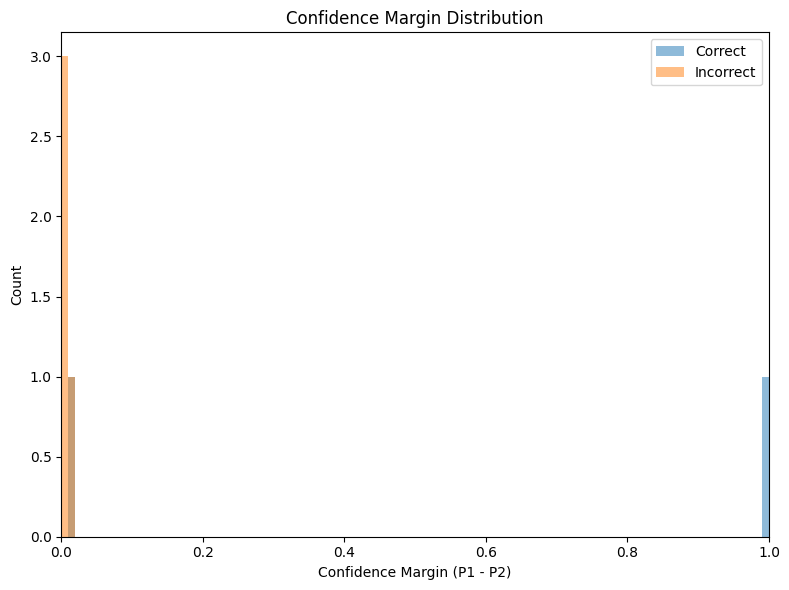


Evaluating on Train Set...
(Sanity Check) Train Set Metrics:
NDCG@1: 0.7391
NDCG@5: 0.8513
NDCG@10: 0.8638
Mean Entropy: 1.8350885718288361


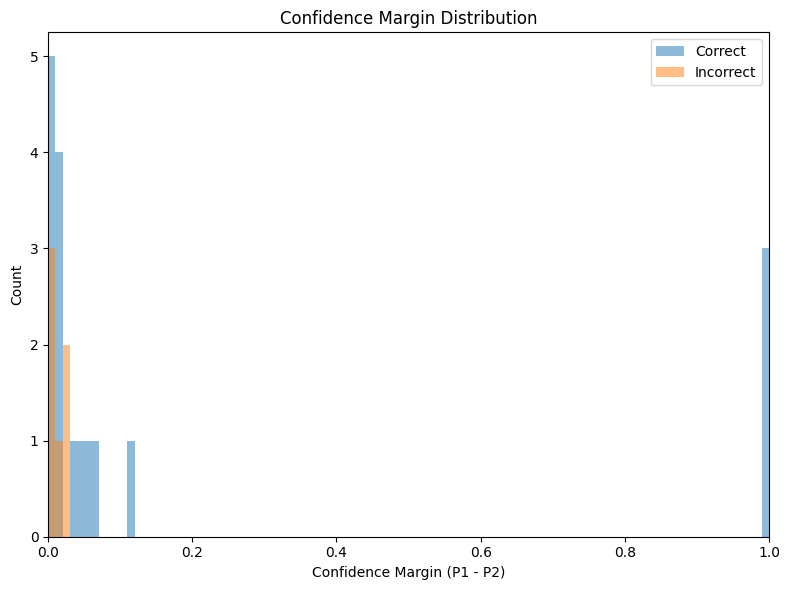

In [8]:
# 予測結果の評価
print("\nEvaluating on Test Set...")
print("Evaluation Results:")

# NDCG / MAP
ndcg = calculate_ndcg(test_df_pred)
for k, score in ndcg.items():
    print(f"NDCG@{k}: {score:.4f}")

# Entropy
entropy_df, mean_entropy = calculate_entropy(test_df_pred)
print("Mean Entropy:", mean_entropy)

# Confidence Margin 可視化
plot_confidence_margin(test_df_pred)



# Sanity Check
print("\nEvaluating on Train Set...")
print("(Sanity Check) Train Set Metrics:")
# NDCG / MAP
ndcg = calculate_ndcg(train_df_pred)
for k, score in ndcg.items():
    print(f"NDCG@{k}: {score:.4f}")

# Entropy
entropy_df, mean_entropy = calculate_entropy(train_df_pred)
print("Mean Entropy:", mean_entropy)

# Confidence Margin 可視化
plot_confidence_margin(train_df_pred)